***Custom Algorithm***



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from datetime import datetime, timedelta
import pytz
import joblib

***Data Collection***

In [2]:
API_KEY = '70ff9507484aa74214bb3005bc88a1bd'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'

In [3]:
data = pd.read_csv('weather.csv')
print(data.shape)
data.head()

(903, 10)


,Date,Temp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,Pressure,Humidity,RainTomorrow
0,1/1/2023 0:00,10.0,4.3,16.3,0.0,135,6.2,1022.4,78.000000,No
1,1/2/2023 0:00,10.1,6.0,17.5,0.0,149,5.4,1023.1,78.000000,No
2,1/3/2023 0:00,10.1,4.2,17.0,0.0,69,4.8,1023.0,75.291667,No
3,1/4/2023 0:00,9.2,5.0,17.5,0.0,184,6.3,1022.7,72.750000,No
4,1/5/2023 0:00,9.5,3.6,18.0,0.6,125,6.0,1024.6,67.708333,Yes


In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           903 non-null    object 
 1   Temp           903 non-null    float64
 2   MinTemp        903 non-null    float64
 3   MaxTemp        903 non-null    float64
 4   Precipitation  898 non-null    float64
 5   WindDir        903 non-null    int64  
 6   WindSpeed      903 non-null    float64
 7   Pressure       903 non-null    float64
 8   Humidity       903 non-null    float64
 9   RainTomorrow   902 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 70.7+ KB


,Temp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,Pressure,Humidity
count,903.000000,903.000000,903.000000,898.000000,903.000000,903.000000,903.000000,903.000000
mean,18.930011,13.747619,25.703765,0.925278,158.825028,7.340532,1015.460354,72.207964
std,5.025509,5.778634,4.796641,7.197946,75.789740,1.629215,4.746337,13.204334
min,8.600000,2.500000,13.900000,0.000000,3.000000,2.600000,1002.100000,24.458333
25%,14.400000,9.000000,21.900000,0.000000,107.500000,6.200000,1012.000000,65.270833
50%,19.800000,14.000000,26.600000,0.000000,151.000000,7.200000,1015.700000,74.291667
75%,23.600000,19.400000,29.700000,0.000000,208.000000,8.450000,1019.400000,80.729167
max,27.200000,23.000000,35.300000,164.300000,358.000000,13.300000,1025.100000,99.833333


In [5]:
print(data.isnull().sum())
print(f"Number of rows : {len(data)}")
print(f"Number of duplicates : {data.duplicated().sum()}")

Date             0
Temp             0
MinTemp          0
MaxTemp          0
Precipitation    5
WindDir          0
WindSpeed        0
Pressure         0
Humidity         0
RainTomorrow     1
dtype: int64
Number of rows : 903
Number of duplicates : 0


***Data Cleaning and Preprocessing***

In [6]:
def preprocess_data(filepath='weather.csv'):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], format='mixed')
    df.set_index('Date', inplace=True)
    df['Precipitation'] = df['Precipitation'].fillna(0)
    if df['RainTomorrow'].dtype == 'object':
        df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
    df.dropna(subset=['RainTomorrow'], inplace=True)
    df['RainTomorrow'] = df['RainTomorrow'].astype(int)
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
    df.dropna(inplace=True)
    return df

In [7]:
print("Processed Data Inspection")
processed_df = preprocess_data(filepath='weather.csv')
print("Data Head")
print(processed_df.head())
print("\n Data Info")
print(processed_df.info())
print("\n Data Describe")
print(processed_df.describe())
print("\n Missing Values Check")
print(processed_df.isnull().sum())
if 'RainTomorrow' in processed_df.columns:
    print("\nRainTomorrow value counts after mapping:")
    print(processed_df['RainTomorrow'].value_counts())

Processed Data Inspection
Data Head
            Temp  MinTemp  MaxTemp  Precipitation  WindDir  WindSpeed  \
Date                                                                    
2023-01-01  10.0      4.3     16.3            0.0      135        6.2   
2023-01-02  10.1      6.0     17.5            0.0      149        5.4   
2023-01-03  10.1      4.2     17.0            0.0       69        4.8   
2023-01-04   9.2      5.0     17.5            0.0      184        6.3   
2023-01-05   9.5      3.6     18.0            0.6      125        6.0   

            Pressure   Humidity  RainTomorrow  
Date                                           
2023-01-01    1022.4  78.000000             0  
2023-01-02    1023.1  78.000000             0  
2023-01-03    1023.0  75.291667             0  
2023-01-04    1022.7  72.750000             0  
2023-01-05    1024.6  67.708333             1  

 Data Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 902 entries, 2023-01-01 to 2025-06-21
Data columns 

 Starting Data Processing 


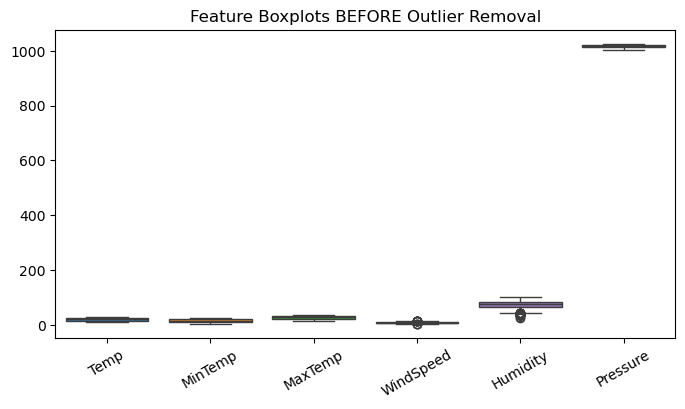

Original number of rows: 903
Number of rows AFTER removing outliers: 860
Rows removed: 43


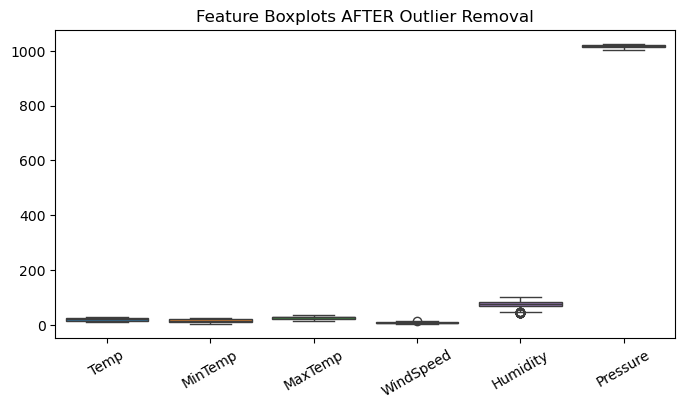

In [8]:
def outlier_check(df):
    df_no_outliers = df.copy()
    outlier_check_cols = ['Temp', 'MinTemp', 'MaxTemp', 'WindSpeed', 'Humidity', 'Pressure']

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_no_outliers[outlier_check_cols])
    plt.title('Feature Boxplots BEFORE Outlier Removal')
    plt.xticks(rotation=30)
    plt.show()

    print(f"Original number of rows: {len(df_no_outliers)}")
    initial_rows = len(df_no_outliers)
    for col in outlier_check_cols:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    print(f"Number of rows AFTER removing outliers: {len(df_no_outliers)}")
    print(f"Rows removed: {initial_rows - len(df_no_outliers)}")
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_no_outliers[outlier_check_cols])
    plt.title('Feature Boxplots AFTER Outlier Removal')
    plt.xticks(rotation=30)
    plt.show()
    return df_no_outliers

print(" Starting Data Processing ")
initial_df = pd.read_csv('weather.csv')
df_no_outliers = outlier_check(initial_df)

In [9]:
def features(df):
    featured_df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(featured_df.index):
        featured_df.index = pd.to_datetime(featured_df['Date'])

    if 'RainTomorrow' in featured_df.columns and featured_df['RainTomorrow'].dtype == 'object':
        featured_df['RainTomorrow'] = featured_df['RainTomorrow'].map({'Yes': 1, 'No': 0})

    featured_df['day_of_year'] = featured_df.index.dayofyear
    featured_df['month'] = featured_df.index.month
    featured_df['day_of_week'] = featured_df.index.dayofweek

    featured_df.dropna(inplace=True)
    return featured_df

print(" Applying Simplified Features")
featured_df = features(df_no_outliers)
FEATURES = [
    'MinTemp', 'MaxTemp', 'Precipitation', 'WindDir', 'Pressure',
    'WindSpeed', 'Temp', 'Humidity', 
    'day_of_year', 'month', 'day_of_week'
]
TARGET_RAIN = 'RainTomorrow'
TARGET_TEMP = 'Temp'
TARGET_HUMIDITY = 'Humidity'

print(f"New features for modeling: {FEATURES}")
print(f"\nFinal DataFrame (with new features): \n{featured_df.head()}")

 Applying Simplified Features
New features for modeling: ['MinTemp', 'MaxTemp', 'Precipitation', 'WindDir', 'Pressure', 'WindSpeed', 'Temp', 'Humidity', 'day_of_year', 'month', 'day_of_week']

Final DataFrame (with new features): 
                     Date  Temp  MinTemp  MaxTemp  Precipitation  WindDir  \
Date                                                                        
2023-01-01  1/1/2023 0:00  10.0      4.3     16.3            0.0      135   
2023-01-02  1/2/2023 0:00  10.1      6.0     17.5            0.0      149   
2023-01-03  1/3/2023 0:00  10.1      4.2     17.0            0.0       69   
2023-01-04  1/4/2023 0:00   9.2      5.0     17.5            0.0      184   
2023-01-05  1/5/2023 0:00   9.5      3.6     18.0            0.6      125   

            WindSpeed  Pressure   Humidity  RainTomorrow  day_of_year  month  \
Date                                                                           
2023-01-01        6.2    1022.4  78.000000           0.0            1

**Data Visualization**


Distribution of the 'RainTomorrow' target variable:
RainTomorrow
0.0    0.639344
1.0    0.360656
Name: proportion, dtype: float64


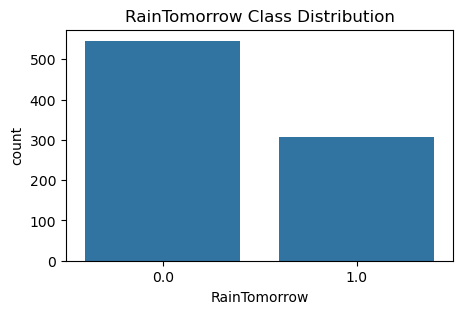

In [10]:
print(f"\nDistribution of the '{TARGET_RAIN}' target variable:")
print(featured_df[TARGET_RAIN].value_counts(normalize=True))
plt.figure(figsize=(5, 3)) 
sns.countplot(x=TARGET_RAIN, data=featured_df)
plt.title('RainTomorrow Class Distribution')
plt.show()


Plotting Feature Correlation Heatmap


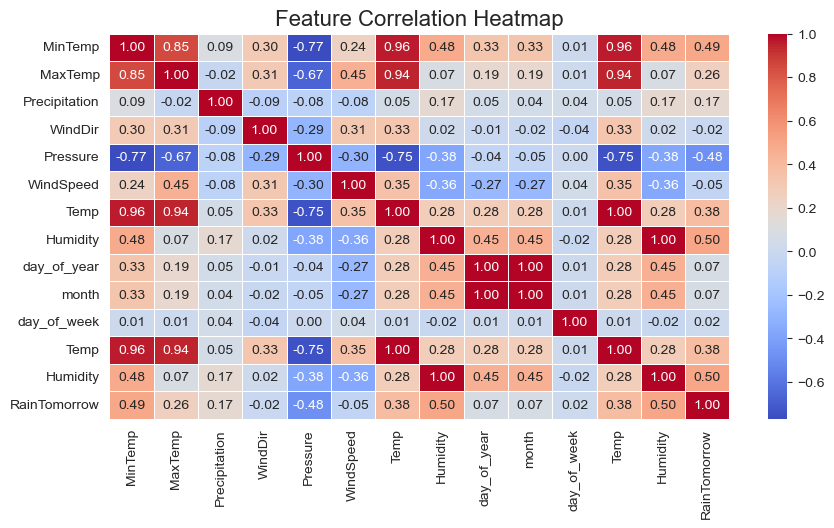

In [11]:
sns.set_style('whitegrid')
# Visualize Feature Correlation with a Heatmap
print("\nPlotting Feature Correlation Heatmap")
plt.figure(figsize=(10, 5))
correlation_matrix = featured_df[FEATURES + [TARGET_TEMP, TARGET_HUMIDITY, TARGET_RAIN]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

Plotting Temperature over time


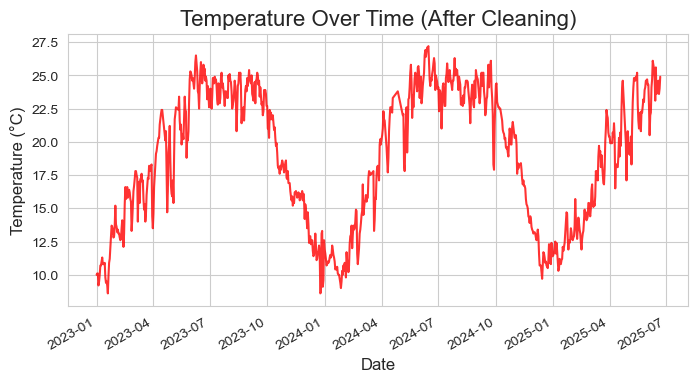

In [12]:
sns.set_style('whitegrid')
print("Plotting Temperature over time")
plt.figure(figsize=(8, 4))
featured_df[TARGET_TEMP].plot(color='red', alpha=0.8)
plt.title('Temperature Over Time (After Cleaning)', fontsize=16)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

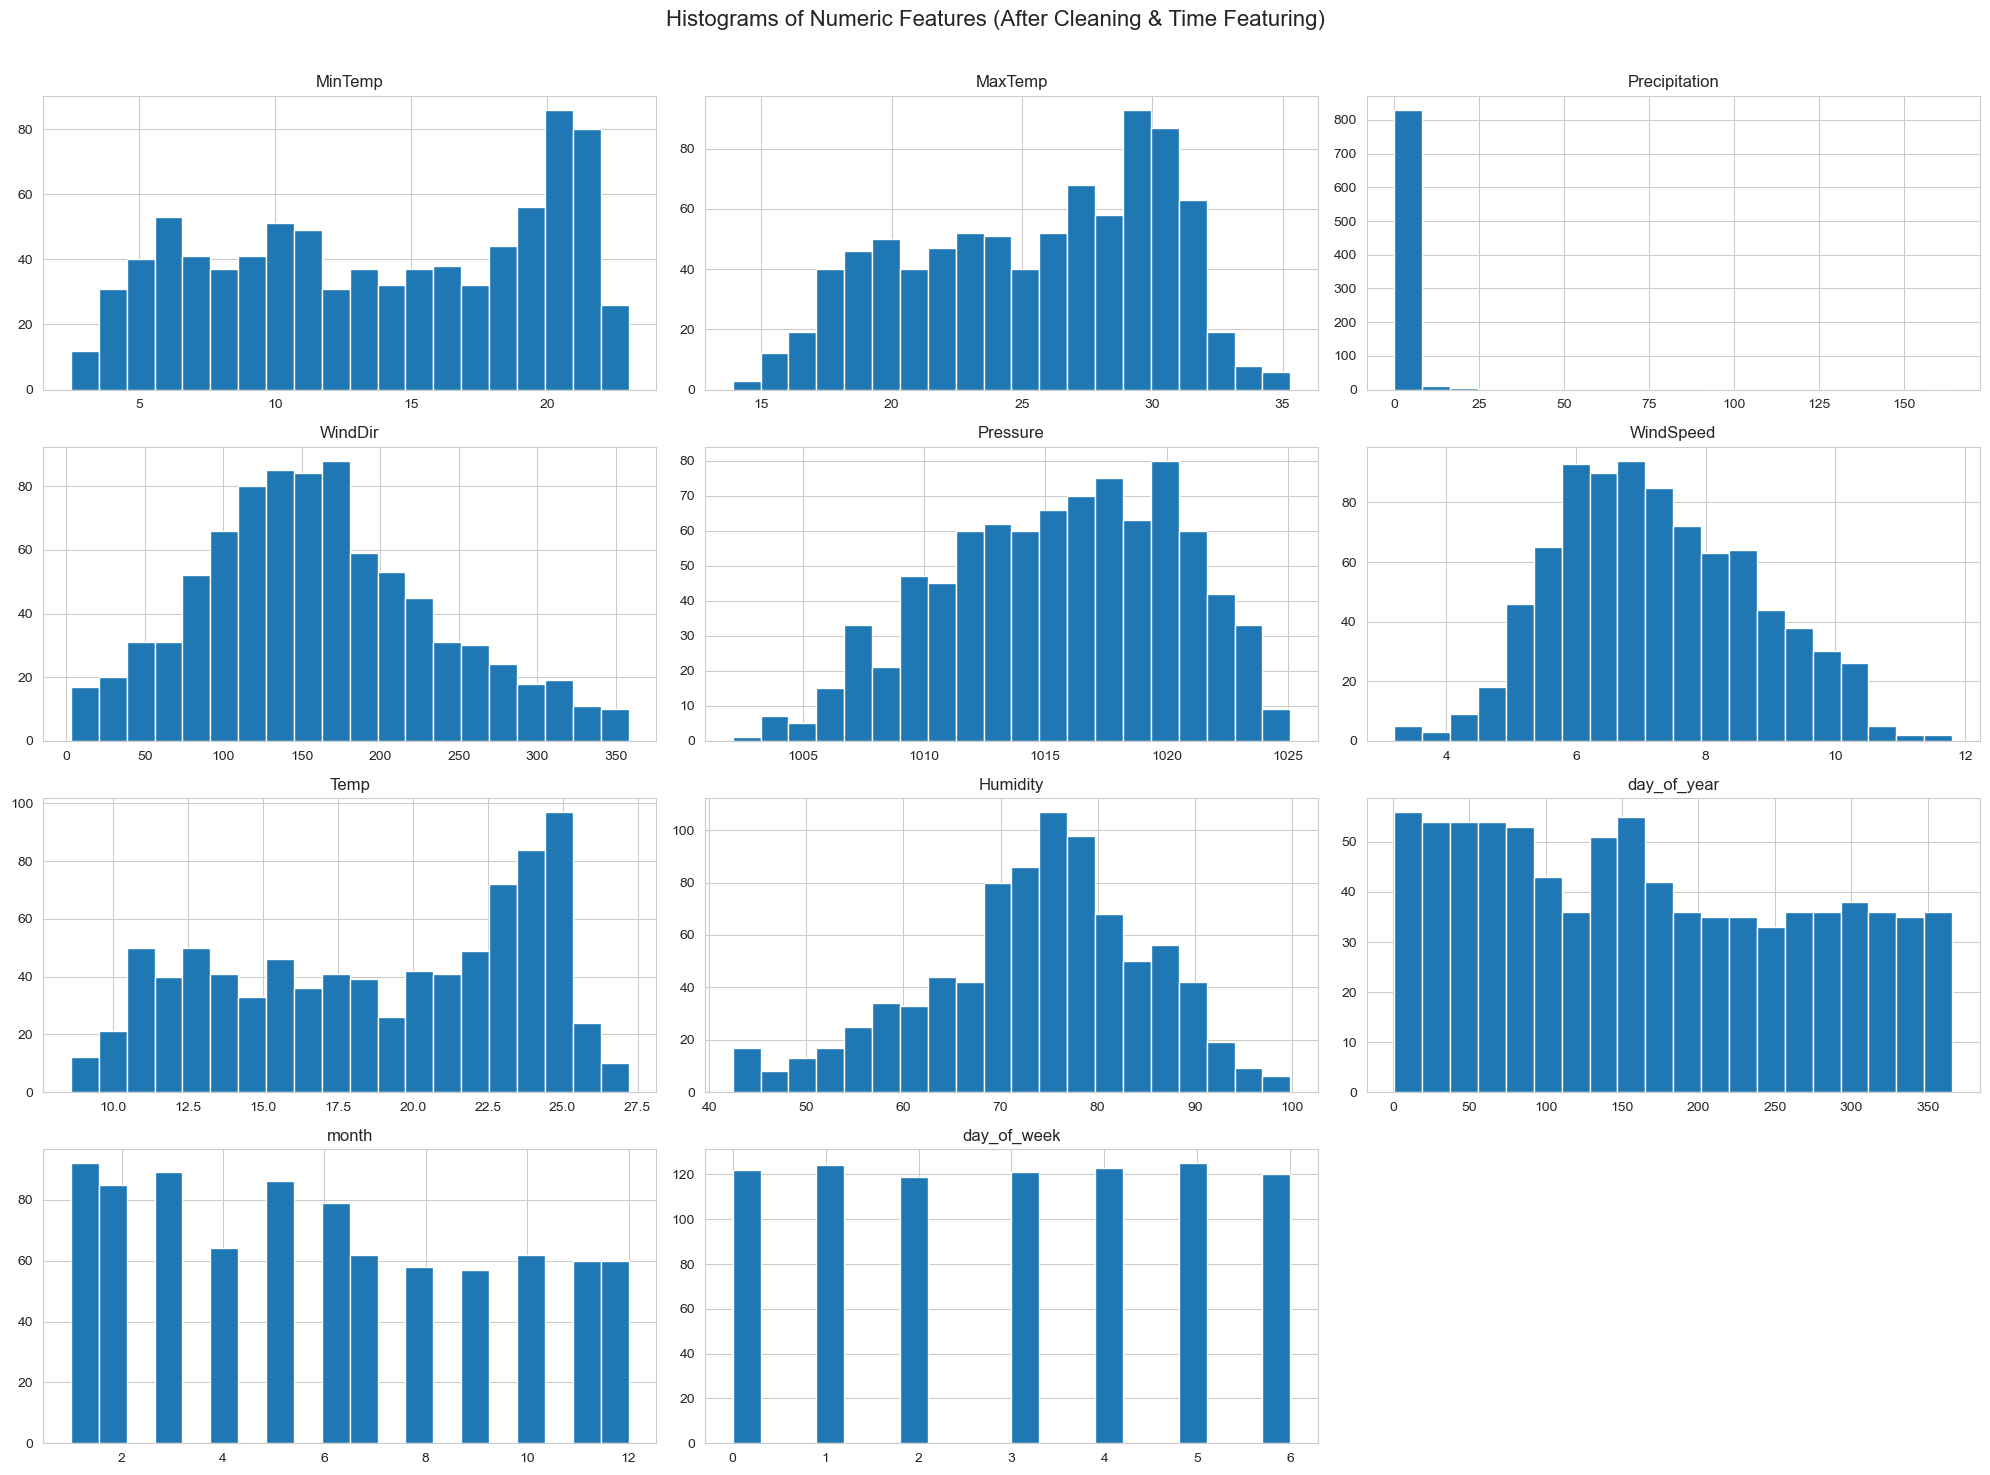

In [13]:
sns.set_style('whitegrid')
featured_df[FEATURES].hist(bins=20, figsize=(20, 15))
plt.suptitle('Histograms of Numeric Features (After Cleaning & Time Featuring)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.show()


**Custom Algorithm**

In [14]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    def is_leaf_node(self):
        return self.value is not None


class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or len(np.unique(y)) == 1 or n_samples < self.min_samples_split):
            return Node(value=self._most_common_label(y))
        best_feat, best_thresh = self._best_criteria(X, y, n_features)
        if best_feat is None: return Node(value=self._most_common_label(y))
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)
    def _best_criteria(self, X, y, n_features):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in range(n_features):
            for threshold in np.unique(X[:, feat_idx]):
                gain = self._information_gain(y, X[:, feat_idx], threshold)
                if gain > best_gain:
                    best_gain, split_idx, split_thresh = gain, feat_idx, threshold
        return split_idx, split_thresh
    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0: return 0
        child_entropy = (len(left_idxs) / len(y)) * self._entropy(y[left_idxs]) + (len(right_idxs) / len(y)) * self._entropy(y[right_idxs])
        return parent_entropy - child_entropy
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    def _entropy(self, y):
        hist = np.bincount(y.astype(int))
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    def _traverse_tree(self, x, node):
        if node.is_leaf_node(): return node.value
        if x[node.feature] <= node.threshold: return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


class RandomForestClassifier:
    def __init__(self, n_trees=100, min_samples_split=2, max_depth=100):
        self.n_trees, self.min_samples_split, self.max_depth = n_trees, min_samples_split, max_depth
        self.trees = []
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree = DecisionTreeClassifier(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    def _bootstrap_samples(self, X, y):
        idxs = np.random.choice(len(X), len(X), replace=True)
        return X[idxs], y[idxs]
    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]
    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees]).T
        return np.array([self._most_common_label(p) for p in preds])

# --- Decision Tree Regressor ---
class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or n_samples < self.min_samples_split):
            return Node(value=np.mean(y))
        best_feat, best_thresh = self._best_split(X, y, n_features)
        if best_feat is None:
            return Node(value=np.mean(y))
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)
    def _best_split(self, X, y, n_features):
        best_mse = float('inf')
        split_idx, split_thresh = None, None
        for feat_idx in range(n_features):
            for threshold in np.unique(X[:, feat_idx]):
                left_idxs, right_idxs = self._split(X[:, feat_idx], threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0: continue
                mse = (len(left_idxs) * np.var(y[left_idxs]) + len(right_idxs) * np.var(y[right_idxs])) / len(y)
                if mse < best_mse:
                    best_mse, split_idx, split_thresh = mse, feat_idx, threshold
        return split_idx, split_thresh
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    def _traverse_tree(self, x, node):
        if node.is_leaf_node(): return node.value
        if x[node.feature] <= node.threshold: return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


class RandomForestRegressor:
    def __init__(self, n_trees=100, min_samples_split=2, max_depth=100):
        self.n_trees, self.min_samples_split, self.max_depth = n_trees, min_samples_split, max_depth
        self.trees = []
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree = DecisionTreeRegressor(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    def _bootstrap_samples(self, X, y):
        idxs = np.random.choice(len(X), len(X), replace=True)
        return X[idxs], y[idxs]
    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)

**Training and Saving trained models**

In [15]:
def prepare_data(df):
    FEATURES = ['MinTemp', 'MaxTemp', 'Precipitation', 'WindDir', 'Pressure',
                'WindSpeed', 'Temp', 'Humidity',
                'day_of_year', 'month', 'day_of_week']
    X = df[FEATURES].values
    y_rain = df[TARGET_RAIN].values
    y_temp = df[TARGET_TEMP].values
    y_humidity = df[TARGET_HUMIDITY].values
    return X, y_rain, y_temp, y_humidity, FEATURES

def train_and_save_models(df, save_path='.'):
    X, y_rain, y_temp, y_humidity, FEATURES = prepare_data(df)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train_rain, y_test_rain = y_rain[:train_size], y_rain[train_size:]
    y_train_temp, y_test_temp = y_temp[:train_size], y_temp[train_size:]
    y_train_humidity, y_test_humidity = y_humidity[:train_size], y_humidity[train_size:]

    print("\nTraining Models")
    rain_model = RandomForestClassifier(n_trees=50, max_depth=10)
    rain_model.fit(X_train, y_train_rain)
    print("Rain model trained.")

    temp_model = RandomForestRegressor(n_trees=50, max_depth=10)
    temp_model.fit(X_train, y_train_temp)
    print("Temperature model trained.")

    humidity_model = RandomForestRegressor(n_trees=50, max_depth=10)
    humidity_model.fit(X_train, y_train_humidity)
    print("Humidity model trained.")
    
    joblib.dump(rain_model, f'{save_path}/rain_model.joblib')
    joblib.dump(temp_model, f'{save_path}/temp_model.joblib')
    joblib.dump(humidity_model, f'{save_path}/humidity_model.joblib')
    joblib.dump(FEATURES, f'{save_path}/features.joblib')
    
    print("\nAll models saved successfully.")

    results = {
        "rain_model": rain_model, "temp_model": temp_model, "humidity_model": humidity_model,
        "X_test": X_test, "y_test_rain": y_test_rain,
        "y_test_temp": y_test_temp, "y_test_humidity": y_test_humidity
    }
    return results
results = train_and_save_models(featured_df)



Training Models
Rain model trained.
Temperature model trained.
Humidity model trained.

All models saved successfully.


**Evaluating Models**

In [16]:
def evaluate_models(results):
    print(" Model Evaluation on Unseen Test Data ")
    rain_model = results["rain_model"]
    temp_model = results["temp_model"]
    humidity_model = results["humidity_model"]
    X_test = results["X_test"]
    y_test_rain = results["y_test_rain"]
    y_test_temp = results["y_test_temp"]
    y_test_humidity = results["y_test_humidity"]

    print("\n Rain Model Evaluation ")
    rain_preds = rain_model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test_rain, rain_preds):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test_rain, rain_preds, target_names=['No Rain', 'Rain']))

    print("\nTemperature Model Evaluation ")
    temp_preds = temp_model.predict(X_test)
    temp_mse = mean_squared_error(y_test_temp, temp_preds)
    temp_rmse = np.sqrt(temp_mse) 
    temp_mae = mean_absolute_error(y_test_temp, temp_preds)

    print(f"Mean Absolute Error (MAE):   {temp_mae:.2f} °C")
    print(f"Mean Squared Error (MSE):    {temp_mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {temp_rmse:.2f}")

    print("\nHumidity Model Evaluation")
    humidity_preds = humidity_model.predict(X_test)
    humidity_mse = mean_squared_error(y_test_humidity, humidity_preds)
    humidity_rmse = np.sqrt(humidity_mse)
    humidity_mae = mean_absolute_error(y_test_humidity, humidity_preds)

    print(f"Mean Absolute Error (MAE):   {humidity_mae:.2f} %")
    print(f"Mean Squared Error (MSE):    {humidity_mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {humidity_rmse:.2f}")
evaluate_models(results)

 Model Evaluation on Unseen Test Data 

 Rain Model Evaluation 
Accuracy: 87.13%

Classification Report:
              precision    recall  f1-score   support

     No Rain       0.99      0.83      0.90       121
        Rain       0.70      0.98      0.82        50

    accuracy                           0.87       171
   macro avg       0.85      0.90      0.86       171
weighted avg       0.91      0.87      0.88       171


Temperature Model Evaluation 
Mean Absolute Error (MAE):   0.03 °C
Mean Squared Error (MSE):    0.00
Root Mean Squared Error (RMSE): 0.05

Humidity Model Evaluation
Mean Absolute Error (MAE):   0.12 %
Mean Squared Error (MSE):    0.04
Root Mean Squared Error (RMSE): 0.20


In [17]:
def predict_future(model, current_features, features_loaded):
    predictions = [current_features['Temp']] if 'Temp' in current_features else [current_features['Humidity']]
    feature_data = current_features.copy()
    for i in range(5):
        now = datetime.now(pytz.timezone('Asia/Kathmandu'))
        feature_data['day_of_year'] = now.timetuple().tm_yday
        feature_data['month'] = now.month
        feature_data['day_of_week'] = now.weekday()
        prediction_df = pd.DataFrame([feature_data])[features_loaded]
        next_value = model.predict(prediction_df.values)[0]
        predictions.append(next_value)
        if 'Temp' in current_features:
            feature_data['Temp'] = next_value
        else:
            feature_data['Humidity'] = next_value
    return predictions[1:]

***Getting live weather data from API***

In [18]:
def get_current_weather(city, save_path='.'):
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    try:
        response = requests.get(url)
        data = response.json()
        if response.status_code != 200 or ('cod' in data and data['cod'] != 200):
            raise ValueError(f"API error: {data.get('message', 'Unknown error')}")   
        utc_dt = datetime.fromtimestamp(data['dt'], tz=pytz.UTC)
        api_timestamp = utc_dt.strftime('%Y-%m-%d %H:%M:%S UTC')
        print(f"API Data Timestamp: {api_timestamp}")

        precipitation = 0
        if 'rain' in data and '1h' in data['rain']:
            precipitation = float(data['rain']['1h'])

        weather_data = {
            'city': data['name'],
            'current_temp': round(float(data['main'].get('temp'))),
            'feels_like': round(float(data['main'].get('feels_like'))),
            'temp_min': round(float(data['main'].get('temp_min'))),
            'temp_max': round(float(data['main'].get('temp_max'))),
            'humidity': round(float(data['main'].get('humidity'))),
            'description': data['weather'][0].get('description', 'unknown'),
            'country': data['sys'].get('country', 'Unknown'),
            'wind_dir': float(data['wind'].get('deg')),
            'wind_speed': float(data['wind'].get('speed')), 
            'pressure': float(data['main'].get('pressure')),
            'precipitation': precipitation, 
            'clouds': int(data['clouds'].get('all')),
            'visibility': int(data.get('visibility'))
        }

        last_row = pd.DataFrame([{
            'Temp': weather_data['current_temp'],
            'MinTemp': weather_data['temp_min'],
            'MaxTemp': weather_data['temp_max'],
            'Humidity': weather_data['humidity'],
            'Pressure': weather_data['pressure'],
            'WindSpeed': weather_data['wind_speed'] * 3.6,
            'WindDir': weather_data['wind_dir'],
            'Precipitation': weather_data['precipitation'],
            'RainTomorrow': None
        }])
        joblib.dump(last_row, f'{save_path}/last_day.joblib')
        print(f"Successfully fetched API Data for {city}.")
        return weather_data
    except (requests.RequestException, ValueError, KeyError) as e:
        print(f"API Request Failed for {city}: {e}. Using fallback data.")
        try:
            last_row = joblib.load('last_day_data.joblib').iloc[0]
            print("Using fallback data from the last day of the dataset.")
            return {
                'city': city,
                'current_temp': round(float(last_row['Temp'])),
                'feels_like': round(float(last_row['Temp'])),
                'temp_min': round(float(last_row['MinTemp'])),
                'temp_max': round(float(last_row['MaxTemp'])),
                'humidity': round(float(last_row['Humidity'])),
                'description': 'Data unavailable (fallback)',
                'country': 'Unknown',
                'wind_dir': float(last_row['WindDir']),
                'wind_speed': float(last_row['WindSpeed']), 
                'pressure': float(last_row['Pressure']),
                'precipitation': float(last_row['Precipitation']),
                'clouds': 50,
                'visibility': 10000
            }
        except Exception as fallback_e:
            print(f"Fallback data error: {fallback_e}")
            return None

***Main Function***

In [19]:
try:
    rain_model = joblib.load('rain_model.joblib')
    features_loaded = joblib.load('features.joblib')
    temp_model = joblib.load('temp_model.joblib')
    humidity_model = joblib.load('humidity_model.joblib')
except FileNotFoundError:
    print("Error: Model files not found. Please run the training cell first.")
    rain_model, features_loaded, temp_model, humidity_model = [None] * 4

def weather_view(city=None):
    if not all([rain_model, features_loaded, temp_model, humidity_model]):
        print("Cannot run view; models are not loaded.")
        return

    if city is None:
        try:
            city = input("Enter City Name: ").strip()
        except EOFError:
            print("Error: City name must be provided.")
            return

    if not city:
        print("Error: City name cannot be empty.")
        return

    current_weather = get_current_weather(city)
    if not current_weather:
        print("Error: Failed to fetch current weather.")
        return

    timezone = pytz.timezone('Asia/Kathmandu')
    now = datetime.now(timezone)
    next_hour = now + timedelta(hours=1)
    next_hour = next_hour.replace(minute=0, second=0, microsecond=0)
    future_times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(5)]

    current_data_for_prediction = {
        'MinTemp': current_weather['temp_min'],
        'MaxTemp': current_weather['temp_max'],
        'Precipitation': current_weather.get('precipitation', 0),
        'WindDir': current_weather['wind_dir'],
        'Pressure': current_weather['pressure'],
        'WindSpeed': current_weather['wind_speed'] * 3.6,
        'Temp': current_weather['current_temp'],
        'Humidity': current_weather['humidity'],
        'day_of_year': now.timetuple().tm_yday,
        'month': now.month,
        'day_of_week': now.weekday()
    }

    try:
        current_df = pd.DataFrame([current_data_for_prediction])[features_loaded]
        current_df = current_df.fillna(0)

        rain_prediction = rain_model.predict(current_df.values)[0]
        temp_prediction = temp_model.predict(current_df.values)[0]
        humidity_prediction = humidity_model.predict(current_df.values)[0]

        future_temp_preds = predict_future(temp_model, current_data_for_prediction, features_loaded)
        future_humidity_preds = predict_future(humidity_model, current_data_for_prediction, features_loaded)

        print(f"\nCity: {current_weather['city']}, {current_weather['country']}")
        print(f"Description: {current_weather['description'].capitalize()}")
        print(f"Current Temperature: {current_weather['current_temp']}°C")
        print(f"Feels Like: {current_weather['feels_like']}°C")
        print(f"Humidity: {current_weather['humidity']}%")
        print(f"Wind: {current_weather['wind_speed']:.1f} m/s from {current_weather['wind_dir']}°")
        print(f"Pressure: {current_weather['pressure']} hPa")
        print(f"Prediction for Rain Tomorrow: "
              f"{'A chance of rain' if rain_prediction == 1 else 'No chance of rain'}")
        print("\nFuture Forecast (next 5 hours):")
        print("Temp (°C) | Humidity (%)")
        print("----------|-------------")
        for i in range(5):
            print(f"{round(future_temp_preds[i], 1):<9} | "
                  f"{round(future_humidity_preds[i], 1):<12}")

    except Exception as e:
        print("Error during prediction:", str(e))


np.random.seed(42)
weather_view()

Enter City Name:  Kyiv


API Data Timestamp: 2025-06-23 12:28:30 UTC
Successfully fetched API Data for Kyiv.

City: Kyiv, UA
Description: Scattered clouds
Current Temperature: 24°C
Feels Like: 24°C
Humidity: 55%
Wind: 4.2 m/s from 333.0°
Pressure: 1012.0 hPa
Prediction for Rain Tomorrow: A chance of rain

Future Forecast (next 5 hours):
Temp (°C) | Humidity (%)
----------|-------------
24.0      | 55.2        
24.1      | 55.2        
24.1      | 55.2        
24.1      | 55.2        
24.1      | 55.2        
